<h1 style="text-align: center;">Hit Analyzer</h1>
<h2 style="text-align: center;">By: Thomas Giewont, Shreyas Vaidya, and Thomas Varano</h2>

<br>
<h3 style="text-align: center;">Introduction</h3>
<p> This is the Introduction. </p>

<h3 style="text-align: center;">Imports and Data Setup</h3>

In [41]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import json

<h3 style="text-align: center;">Data Collection and Curation</h3>

In [2]:
df = pd.read_csv('https://query.data.world/s/aofqalvgkuabshmmlxm32rxk3t3yiq')

In [3]:
df = df.drop(columns=['url'])
df = df.rename(columns={'WeekID': 'week', 'Week Position': 'week_position', 'Song': 'song', 'Performer': 'performer', 'SongID': 'songid', 'Instance': 'instance', 'Previous Week Position': 'prev_week_position', 'Peak Position': 'peak_position', 'Weeks on Chart': 'weeks_on_chart'})

In [4]:
df = df.astype({"week": 'datetime64'})

In [5]:
# stuff after 2000... obvi remove
df = df[df.week > pd.to_datetime(datetime.date(2000, 1, 1))]


In [6]:
# make a copy incase we fuck some data
dfcpy = df.copy()

In [7]:
# restore df
df = dfcpy.copy()

<h3 style="text-align: center;">Data Analysis</h3>

#### Hypothesis:
We believe that every song follows a similar trend when they reach the Billboard Top 100.

In [8]:
# remove weird nans
# tm = df.loc[:, df.columns != 'prev_week_position']
df = df.dropna(subset=['week', 'week_position', 'song', 'performer', 'songid', 'instance', 'peak_position', 'weeks_on_chart'])


In [9]:
df[df.prev_week_position.isna()]


,week,week_position,song,performer,songid,instance,prev_week_position,peak_position,weeks_on_chart
197,2001-02-17,79,Don't Talk,Jon B,Don't TalkJon B,1.0,NaN,79.0,1.0
213,2014-07-12,89,Don't Tell 'Em,Jeremih Featuring YG,Don't Tell 'EmJeremih Featuring YG,1.0,NaN,89.0,1.0
291,2004-04-03,65,Don't Tell Me,Avril Lavigne,Don't Tell MeAvril Lavigne,1.0,NaN,65.0,1.0
311,2000-12-09,78,Don't Tell Me,Madonna,Don't Tell MeMadonna,1.0,NaN,78.0,1.0
322,2019-12-07,55,Into The Unknown,Idina Menzel & AURORA,Into The UnknownIdina Menzel & AURORA,1.0,NaN,55.0,1.0
...,...,...,...,...,...,...,...,...,...
325591,2008-07-05,93,You Look Good In My Shirt,Keith Urban,You Look Good In My ShirtKeith Urban,1.0,NaN,93.0,1.0
325608,2017-04-22,60,You Look Good,Lady Antebellum,You Look GoodLady Antebellum,1.0,NaN,60.0,1.0
325611,2017-05-20,94,You Look Good,Lady Antebellum,You Look GoodLady Antebellum,2.0,NaN,94.0,4.0
325628,2016-08-27,100,You Look Like I Need A Drink,Justin Moore,You Look Like I Need A DrinkJustin Moore,1.0,NaN,100.0,1.0


In [10]:
# make dataframe to keep track of song-wide data

song_info = df.drop_duplicates(subset=['songid']).drop(columns=['week', 'week_position', 'instance', 'prev_week_position', 'peak_position', 'weeks_on_chart']).set_index('songid')
# song_info = pd.DataFrame(data=[tmp_df.songid, tmp_df.song, tmp_df.song])
# song_info = {s: {'song': r.song, 'performer': r.song} for s, r in tmp_df.iterrows()}

In [24]:
df[df.songid=='BabyJustin Bieber Featuring Ludacris']

,week,week_position,song,performer,songid,instance,prev_week_position,weeks_on_chart,rel_week
27,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,8.0,7.0
872,2010-02-06,5,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,NaN,1.0,0.0
20955,2010-04-03,10,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,12.0,9.0,8.0
38947,2010-04-10,8,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,10.0,10.0,9.0
63761,2010-04-24,9,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,8.0,12.0,11.0
77672,2010-04-17,8,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,8.0,11.0,10.0
83910,2010-05-08,21,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,16.0,14.0,13.0
98838,2010-02-13,25,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,5.0,2.0,1.0
144451,2010-05-15,26,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,21.0,15.0,14.0
145078,2010-06-05,38,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,38.0,18.0,17.0


In [11]:
song_info

,song,performer
songid,,
Dance MonkeyTones And I,Dance Monkey,Tones And I
Run It!Chris Brown,Run It!,Chris Brown
BabyJustin Bieber Featuring Ludacris,Baby,Justin Bieber Featuring Ludacris
Pray For MeThe Weeknd & Kendrick Lamar,Pray For Me,The Weeknd & Kendrick Lamar
Blow Me (One Last Kiss)P!nk,Blow Me (One Last Kiss),P!nk
...,...,...
You Know You're RightNirvana,You Know You're Right,Nirvana
You LieThe Band Perry,You Lie,The Band Perry
You Look Good In My ShirtKeith Urban,You Look Good In My Shirt,Keith Urban


In [12]:
# get the absolute peak for each song
for s in list(song_info.index.values): 
    song_info.at[s, 'peak'] = min(df[df.songid == s].week_position.unique())

df = df[[(song_info.loc[r.songid].peak <= 10) for _, r in df.iterrows()]]
song_info = song_info[song_info.peak <= 10]


In [13]:
# only keep the songs that peaked in the top 10
df = df.drop(columns=['peak_position'])


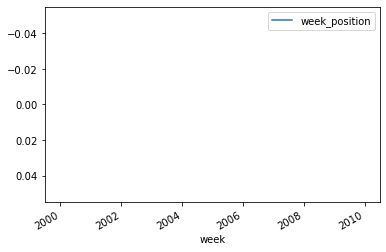

In [14]:
ax = plt.gca()
# for s in df.song.unique(): 
s = "Satisfy YouPuff Daddy Featuring R. Kelly"
df[df.songid == s].plot(x='week', y='week_position', ax = ax)
horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
plt.gca().invert_yaxis()
# print(min(pk))

In [15]:
# control points col
# (start, start_peak, end_peak, end)


In [16]:
# finding time before peak
# find when week_position == peak
# find the smallest weekid for my song
# subtract

# first hot week
# df.days_to_hot = np.nan


for s in df.songid.unique():

    song_instances = df[df.songid == s].sort_values(by='week')

    if len(song_instances[song_instances.week_position <= 10].week) != 0: 
        week = 1
        
        # get all peaks and their weeks
        # inflection points of graph in form: 
        # tuple (date, begin), where begin is true if the inflection point is beginning a hot spell
        inflections = []
        longest_peak = []

        # if the first week is already in the top 10
        if song_instances.iloc[0].week_position <= 10: 
            inflections.append((song_instances.iloc[0].week, True))


        for i in range(1, len(song_instances)): 
                
            if song_instances.iloc[i].week_position <= 10 and song_instances.iloc[i - 1].week_position > 10: 
                # this is for grace period
                if i > 1 and song_instances.iloc[i-2].week_position <= 10: 
                    # remove the last ending guy
                        inflections.remove(inflections[len(inflections) - 1])
                else: 
                    # if not beginning after a grace period, 
                    inflections.append((song_instances.iloc[i].week, True))
            elif song_instances.iloc[i].week_position > 10 and song_instances.iloc[i - 1].week_position <= 10:
                inflections.append((song_instances.iloc[i - 1].week, False))
   
        # if the song finished in the top 10 and dropped off the charts
        if song_instances.iloc[len(song_instances) - 1].week_position <= 10: 
            inflections.append((song_instances.iloc[len(song_instances) - 1].week, False))

        for i in range(0, len(inflections)-1):
            longest_date = datetime.timedelta(0)
            if len(inflections) == 0 or len(inflections) == 1:
                longest_peak = inflections
            else:
                # TODO look for better ways to find relevant peak (eg. height, top position, etc)
                if inflections[i][1] is True and inflections[i+1][1] is False:
                    if inflections[i+1][0] - inflections[i][0] >= longest_date:
                        longest_date = inflections[i+1][0] - inflections[i][0]
                        longest_peak = []
                        longest_peak.append(inflections[i])
                        longest_peak.append(inflections[i+1])

            # longest peak is relevant peak we care about

        song_info.loc[s, 'start_week'] = min(song_instances.week)
        song_info.loc[s, 'end_week'] = max(song_instances.week)
        song_info.loc[s, 'start_peak'] = longest_peak[0][0]
        song_info.loc[s, 'end_peak'] = longest_peak[1][0]
        # control_pts[s] = (min(song_instances.week), max(song_instances.week), longest_peak[0][0], longest_peak[1][0])
    
        
        # print(s)
        # print(longest_peak)         
                

/home/tvarano/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/tvarano/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [17]:
# JUST A NOTE these guys dont have peaks because they already hit their peaks before
song_info

,song,performer,peak,start_week,end_week,start_peak,end_peak
songid,,,,,,,
Dance MonkeyTones And I,Dance Monkey,Tones And I,9.0,2019-10-19,2019-12-28,2019-12-21,2019-12-21
Run It!Chris Brown,Run It!,Chris Brown,1.0,2005-08-27,2006-05-13,2005-10-22,2006-02-11
BabyJustin Bieber Featuring Ludacris,Baby,Justin Bieber Featuring Ludacris,5.0,2010-02-06,2010-06-19,2010-04-03,2010-04-24
Pray For MeThe Weeknd & Kendrick Lamar,Pray For Me,The Weeknd & Kendrick Lamar,7.0,2018-02-17,2018-06-30,2018-02-17,2018-03-31
Blow Me (One Last Kiss)P!nk,Blow Me (One Last Kiss),P!nk,5.0,2012-07-21,2013-01-19,2012-09-22,2012-11-03
...,...,...,...,...,...,...,...
The Edge Of GloryLady Gaga,The Edge Of Glory,Lady Gaga,3.0,2011-05-28,2011-11-05,2011-05-28,2011-08-13
The FoxYlvis,The Fox,Ylvis,6.0,2013-09-21,2014-01-18,2013-10-12,2013-11-09
The Game Of LoveSantana Featuring Michelle Branch,The Game Of Love,Santana Featuring Michelle Branch,5.0,2002-10-05,2003-06-14,2002-11-02,2003-01-18


In [18]:
# note we had to deal with prince popping back up on the charts after he died (and we might be dead by tomorrowsoko)
# dealt with those weirdly
# and then also guys that peaked one week and dipped

In [28]:
# make weeks to hot and weeks hot

for i, r in song_info.iterrows(): 
    song_info.loc[i, 'weeks_to_hot'] = (r.start_peak - r.start_week).days / 7
    song_info.loc[i, 'weeks_hot'] = (r.end_peak - r.start_peak).days / 7 + 1
    song_info.loc[i, 'tail_weeks'] = (r.end_week - r.end_peak).days / 7

song_info = song_info.astype({"weeks_to_hot": 'float', "weeks_hot": 'float', "tail_weeks": 'float'})


In [20]:
for i, r in df.iterrows(): 
    df.at[i, 'rel_week'] = (r.week - song_info.loc[r.songid].start_week).days / 7

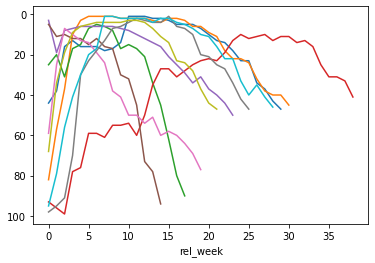

In [21]:
# a couple graphs to make pretty and look at
# song_info[song_info.weeks_to_hot <= 52].hist(column='weeks_to_hot')
# song_info[song_info.weeks_hot <= 25].hist(column='weeks_hot')
# song_info[song_info.tail_weeks <= 52].hist(column='tail_weeks')
sngs = song_info.sample(n=10).index.values
ax = plt.gca()
tmp = df.sort_values(by='week')
for s in sngs: 
    tmp[tmp.songid == s].plot(x='rel_week', y='week_position', ax=ax)
plt.gca().invert_yaxis()
ax.get_legend().remove()
plt.show()

In [36]:
# More data points 
# time at peak value

# TODO REWRITE THIS
for s in df.songid.unique(): 
    song_inst = df[df.songid == s]

    # time above 10 total
    song_info.at[s, 'time_at_top_10'] = len(song_inst[song_inst.week_position <= 10])

    # slope of the climb
    # abs(start_peak.week_position - start_week.week_position)
    pos_climbed = abs(int(song_inst[song_inst.week == song_info.loc[s, 'start_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'start_week']].week_position))
    # if the song started on the chart, make the slope -1. else, make it (how many positions it climbed) / (how long the climb was)
    song_info.loc[s, 'climb_slope'] = -1 if song_info.loc[s, 'weeks_to_hot'] == 0 else (pos_climbed/song_info.loc[s, 'weeks_to_hot'])

    # slope of the tail (-1 if it just fell off the charts)
    # abs(end_peak.week_position - end_week.week_position)
    pos_lost = abs(int(song_inst[song_inst.week == song_info.loc[s, 'end_peak']].week_position) - int(song_inst[song_inst.week == song_info.loc[s, 'end_week']].week_position))
    # song_info.loc[s, 'tail_slope'] = -1 if df[df.songid == s].tail_weeks.values[0] == 0 else (pos_lost/df[df.songid == s].tail_weeks.values[0]
    song_info.loc[s, 'tail_slope'] = -1 if song_info.loc[s, 'tail_weeks'] == 0 else (pos_lost/song_info.loc[s, 'tail_weeks'])
    # average value
    song_info.at[s, 'avg_position'] = song_inst.week_position.mean()
    # weeks on chart
    song_info.at[s, 'weeks_on_chart'] = max(song_inst.weeks_on_chart)
    # instance
    song_info.at[s, 'instance'] = max(song_inst.instance)



In [37]:
song_info# print(df[(df.songid == s) & (df.week == df.start_peak)].week_position)
# print(df[(df.songid == s) & (df.week == df.start_week)].week_position)

,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance
songid,,,,,,,,,,,,,,,,
Dance MonkeyTones And I,Dance Monkey,Tones And I,9.0,2019-10-19,2019-12-28,2019-12-21,2019-12-21,9.0,1.0,1.0,1.0,9.666667,2.000000,33.818182,11.0,1.0
Run It!Chris Brown,Run It!,Chris Brown,1.0,2005-08-27,2006-05-13,2005-10-22,2006-02-11,8.0,17.0,13.0,17.0,10.500000,3.076923,22.368421,38.0,1.0
BabyJustin Bieber Featuring Ludacris,Baby,Justin Bieber Featuring Ludacris,5.0,2010-02-06,2010-06-19,2010-04-03,2010-04-24,8.0,4.0,8.0,5.0,0.625000,5.375000,22.000000,20.0,1.0
Pray For MeThe Weeknd & Kendrick Lamar,Pray For Me,The Weeknd & Kendrick Lamar,7.0,2018-02-17,2018-06-30,2018-02-17,2018-03-31,0.0,7.0,13.0,6.0,-1.000000,3.923077,21.250000,20.0,1.0
Blow Me (One Last Kiss)P!nk,Blow Me (One Last Kiss),P!nk,5.0,2012-07-21,2013-01-19,2012-09-22,2012-11-03,9.0,7.0,11.0,11.0,5.777778,3.363636,19.629630,27.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Edge Of GloryLady Gaga,The Edge Of Glory,Lady Gaga,3.0,2011-05-28,2011-11-05,2011-05-28,2011-08-13,0.0,12.0,12.0,11.0,-1.000000,3.333333,18.541667,24.0,1.0
The FoxYlvis,The Fox,Ylvis,6.0,2013-09-21,2014-01-18,2013-10-12,2013-11-09,3.0,5.0,10.0,5.0,7.000000,6.500000,44.944444,18.0,1.0
The Game Of LoveSantana Featuring Michelle Branch,The Game Of Love,Santana Featuring Michelle Branch,5.0,2002-10-05,2003-06-14,2002-11-02,2003-01-18,4.0,12.0,21.0,11.0,14.250000,1.904762,22.540541,37.0,1.0


# MERGING TOM Gs STUFF

In [45]:
train = song_info.copy()[['peak', 'weeks_on_chart', 'weeks_hot', 'weeks_to_hot', 'instance', 'tail_weeks' ]]
train = train.reset_index().drop(columns=['songid'])

1126

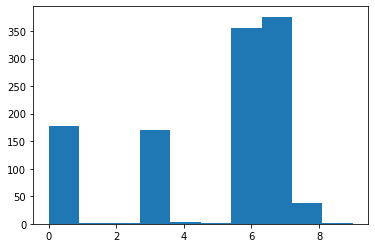

In [47]:
#Sets a random state so we get the same results every time
random_state = 170
#for now 
model = KMeans(n_clusters=10, random_state = random_state)
model.fit(train.to_numpy())
all_predictions = model.predict(train.to_numpy())
plt.hist(all_predictions)
len(all_predictions)

In [53]:
#assigns the cluster number to the train dataframe for each corresponding song
# for i,r in train.iterrows():
song_info.insert(len(song_info.columns), "group", all_predictions)

In [54]:
song_info

,group,song,performer,peak,start_week,end_week,start_peak,end_peak,weeks_to_hot,weeks_hot,tail_weeks,time_at_top_10,climb_slope,tail_slope,avg_position,weeks_on_chart,instance
songid,,,,,,,,,,,,,,,,,
Dance MonkeyTones And I,6,Dance Monkey,Tones And I,9.0,2019-10-19,2019-12-28,2019-12-21,2019-12-21,9.0,1.0,1.0,1.0,9.666667,2.000000,33.818182,11.0,1.0
Run It!Chris Brown,0,Run It!,Chris Brown,1.0,2005-08-27,2006-05-13,2005-10-22,2006-02-11,8.0,17.0,13.0,17.0,10.500000,3.076923,22.368421,38.0,1.0
BabyJustin Bieber Featuring Ludacris,6,Baby,Justin Bieber Featuring Ludacris,5.0,2010-02-06,2010-06-19,2010-04-03,2010-04-24,8.0,4.0,8.0,5.0,0.625000,5.375000,22.000000,20.0,1.0
Pray For MeThe Weeknd & Kendrick Lamar,6,Pray For Me,The Weeknd & Kendrick Lamar,7.0,2018-02-17,2018-06-30,2018-02-17,2018-03-31,0.0,7.0,13.0,6.0,-1.000000,3.923077,21.250000,20.0,1.0
Blow Me (One Last Kiss)P!nk,7,Blow Me (One Last Kiss),P!nk,5.0,2012-07-21,2013-01-19,2012-09-22,2012-11-03,9.0,7.0,11.0,11.0,5.777778,3.363636,19.629630,27.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Edge Of GloryLady Gaga,7,The Edge Of Glory,Lady Gaga,3.0,2011-05-28,2011-11-05,2011-05-28,2011-08-13,0.0,12.0,12.0,11.0,-1.000000,3.333333,18.541667,24.0,1.0
The FoxYlvis,6,The Fox,Ylvis,6.0,2013-09-21,2014-01-18,2013-10-12,2013-11-09,3.0,5.0,10.0,5.0,7.000000,6.500000,44.944444,18.0,1.0
The Game Of LoveSantana Featuring Michelle Branch,0,The Game Of Love,Santana Featuring Michelle Branch,5.0,2002-10-05,2003-06-14,2002-11-02,2003-01-18,4.0,12.0,21.0,11.0,14.250000,1.904762,22.540541,37.0,1.0


In [56]:
#Gets averages for every cluster/group. This code is definitely not the most efficient way and I will probably redo
class Result:
    def __init__(self,peak, wc, wh, wth, inst, tail, group):
        self.peak = peak
        self.wc = wc
        self.wh = wh
        self.wth = wth
        self.inst = inst
        self.tail = tail
        self.group = group
        self.len = 1
    def add(self,peak, wc, wh, wth, inst, tail):
        self.peak += peak
        self.wc += wc
        self.wh += wh
        self.wth += wth
        self.inst += inst
        self.tail += tail
        self.len += 1
    def get(self):
        return {
            "peak": self.peak / self.len,
            "weeks_on_chart": self.wc / self.len,
            "weeks_hot" : self.wh / self.len,
            'weeks_to_hot' : self.wth / self.len,
            'instance' : self.inst / self.len,
            'tail_weeks' : self.tail / self.len,
            'group' : self.group,
            'length' : self.len
        }
    def display(self):
        v = self.get()
        return json.dumps(v)
cluster = {}
for i,r in song_info.iterrows():
    key = r.group
    if key in cluster:
        cluster[key].add(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks)
    else:
        temp = Result(r.peak, r.weeks_on_chart, r.weeks_hot, r.weeks_to_hot, r.instance, r.tail_weeks, key)
        cluster[key] = temp

for c in cluster:
    print(cluster[c].display())

{"peak": 6.729577464788733, "weeks_on_chart": 17.861971830985915, "weeks_hot": 3.016901408450704, "weeks_to_hot": 4.653521126760563, "instance": 1.1098591549295775, "tail_weeks": 10.64225352112676, "group": 6, "length": 355}
{"peak": 2.6123595505617976, "weeks_on_chart": 43.91011235955056, "weeks_hot": 17.359550561797754, "weeks_to_hot": 8.567415730337078, "instance": 1.1404494382022472, "tail_weeks": 17.971910112359552, "group": 0, "length": 178}
{"peak": 2.827127659574468, "weeks_on_chart": 26.64627659574468, "weeks_hot": 12.422872340425531, "weeks_to_hot": 5.321808510638298, "instance": 1.0372340425531914, "tail_weeks": 8.694148936170214, "group": 7, "length": 376}
{"peak": 6.823529411764706, "weeks_on_chart": 31.988235294117647, "weeks_hot": 4.658823529411765, "weeks_to_hot": 18.123529411764707, "instance": 1.2470588235294118, "tail_weeks": 11.876470588235295, "group": 3, "length": 170}
{"peak": 4.351351351351352, "weeks_on_chart": 52.2972972972973, "weeks_hot": 6.297297297297297, 

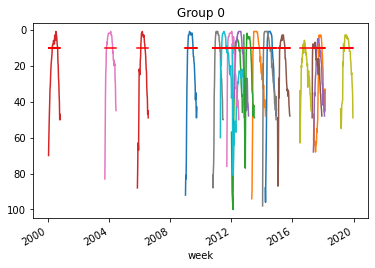

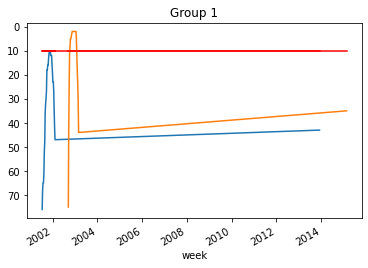

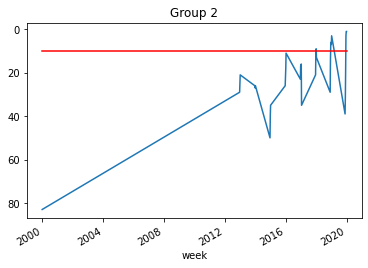

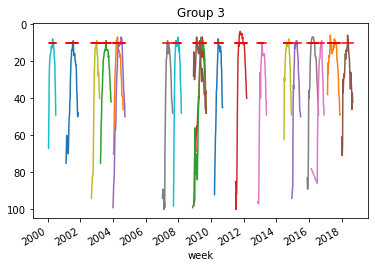

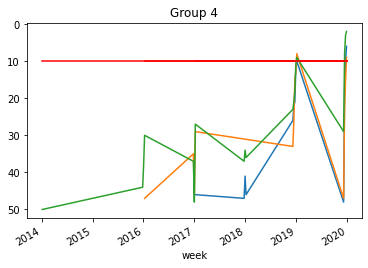

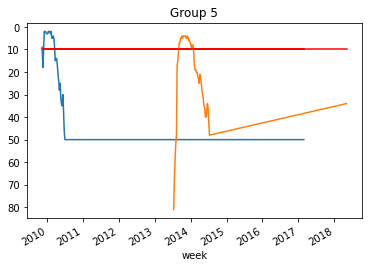

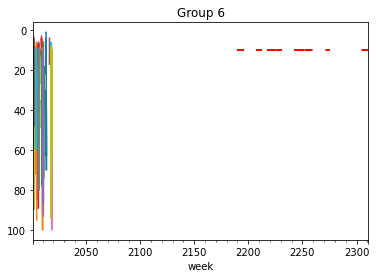

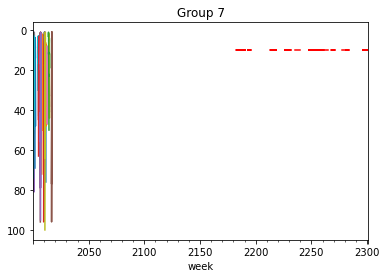

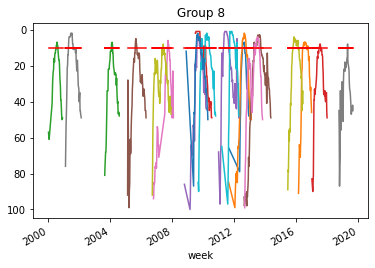

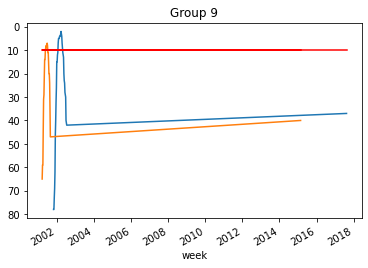

In [60]:
from random import sample
frames = {}
poop = [8,1,4,7]
for c in sorted(cluster):
    temp = song_info[train.group == c].index.values
    if len(temp) > 20:
        temp = sample(temp.tolist(),20)
    ax = plt.gca()
    for s in temp:
    # for s in df.song.unique(): 
        df[df.songid == s].plot(x='week', y='week_position', ax = ax)
        horiz_line_data = np.array([10 for i in range(len(df[df.songid == s]))])
        plt.plot(df[df.songid == s].week, horiz_line_data, 'r') 
    plt.gca().invert_yaxis()
    ax.get_legend().remove()
    plt.title("Group " + str(c))
    plt.show()

In [ ]:
train[train.group == 0]


<h3 style="text-align: center;">Insights Attained</h3>